# Import Libararies

In [1]:
from pathlib import Path
import datetime
import pandas as pd
import plotly.express as px
from pycaret.regression import *

In [ ]:
# create data folder
current_dir = Path.cwd()
DATAPATH = current_dir.parents[0] / 'data'
Path(DATAPATH).mkdir(parents=True, exist_ok=True)

# Utility Functions

In [ ]:
# filter by country
def add_date_to_filename(filename)->str:
    """Add current date to filename"""
    date = datetime.datetime.now()
    date_today = str(date.year)+'-'+str("{:02d}".format(date.month))+'-'+str("{:02d}".format(date.day))
    filename_new = filename + '_' + date_today + '.csv'
    return filename_new

def download_data(url_data, features)->pd.DataFrame:
    """download latest covid data from https://ourworldindata.org and return . Provide the url and the features you want."""
    df = pd.read_csv(url_data, usecols = features)
    # reorder columns
    df = df[features]
    # set date as index
    df.set_index('date', inplace=True)
    # Converting date to index
    df.index = pd.to_datetime(df.index)
    # check number of unique countries
    print('The dataset contains {} different countries'.format(df['location'].nunique())) 
    # check data type
    print('data types: ', df.dtypes)
    return df

def filter_country(dataframe:pd.DataFrame, LOCATION:str):
  """Filter dataframe by country. """
  return dataframe[dataframe.location == LOCATION]

def ts_filling(df_country:pd.DataFrame)->pd.DataFrame:
    """Fill missing data and smooth ts in dataframe of single country"""
    # backfill missing data by 2 months
    df = df_country.copy()
    df.fillna(value=None, method='bfill', axis=0, inplace=True, limit=80, downcast=None)
    # forwardfill missing data by 2 months
    df.fillna(value=None, method='ffill', axis=0, inplace=True, limit=80, downcast=None)
    # smooth time series
    for col in df.columns[1:]:
        df[col] = df[col].rolling(21).median()
    # fill in new nas
    df.fillna(value=None, method='bfill', axis=0, inplace=True, limit=30, downcast=None)
    return df

def drop_countries(df:pd.DataFrame, max_missing_pct=0.1)->pd.DataFrame:
    """Drop countries in df containing all countries with at least onnce column having more than max_missing_pct rows with missing data """
    # generate list of countries to keep
    country_list = [] # list of countries to keep
    for country in df['location'].unique():
        # select country
        df_country = filter_country(df, country)
        # fill nas in ts
        df_country = ts_filling(df_country)
        # if there is still missing data, then drop the country from the dataset
        if df_country.isna().sum().max() < len(df_country) * max_missing_pct:
            country_list.append(country)
    # keep only countries in the list i.e. drop the remaining ones
    return df[df['location'].isin(country_list)]

def add_new_deaths_pct_change(df_country:pd.DataFrame)->pd.DataFrame:
    """calculate percent change between the median number of deaths 14 days earlier and the median number of deaths today"""
    df = df_country.copy()
    df['new_deaths_per_million_pct_change'] = df['new_deaths_per_million'].pct_change(periods=14, fill_method='pad', freq='D')
    df['new_deaths_per_million_pct_change'].fillna(value=None, method='bfill', axis=0, inplace=True, limit=30, downcast=None)
    #df.dropna(axis=0, inplace=True)
    return df

def add_case_fatality_rate(df_country:pd.DataFrame)->pd.DataFrame:
    """calculate case fatality rate CFR for single country df; CFR is the ratio between the 14-day median number of deaths and the 14-day median number of cases 14 days earlier """
    df = df_country.copy()
    df['case_fatality_rate'] = df['new_deaths_per_million'] / df['new_cases_per_million'].shift(14)
    # set inf values to zero i.e. the assumption is when there are no cases then there are no deaths
    df['case_fatality_rate'][df['new_cases_per_million']==0] = 0
    # set na values to zero i.e. the assumption is when there are no deaths and at the same time zero cases, then CFR is still zero
    df['case_fatality_rate'][df['new_deaths_per_million']==0] = 0
    # cfr above 100% makes no sense
    df['case_fatality_rate'][df['case_fatality_rate']>1] = 1
    # do a little smoothing i.e. average over 7 days
    df['case_fatality_rate'] = df['case_fatality_rate'].rolling(7).median()
    # fill in new nas
    df['case_fatality_rate'].fillna(value=None, method='bfill', axis=0, inplace=True, limit=30, downcast=None)
    #df.dropna(axis=0, inplace=True)
    return df

# filter by date
def filter_date(dataframe:pd.DataFrame, start_date:str, end_date:str)->pd.DataFrame:
    """Filter dataframe by date range including start_date and end_date. """
    return dataframe.loc[(dataframe.index >= start_date) & (dataframe.index <= end_date)]

def get_start_end_date(df_country:pd.DataFrame)->str:
    """Get start and end dates in dataframe of single country """
    start_date = str(df_country.index[0])[:-9]
    end_date = str(df_country.index[-1])[:-9]
    return start_date, end_date

def train_test_split(df_country:pd.DataFrame, split_date:str)->pd.DataFrame:
    """Split into train and test given a split date"""
    start_date, end_date = get_start_end_date(df_country)
    day_after_split_date = str(pd.to_datetime(split_date) + pd.DateOffset(days=1))[:-9]
    df_train = filter_date(df_country, start_date=start_date, end_date=split_date)
    df_test = filter_date(df_country, start_date=day_after_split_date, end_date=end_date) 
    return df_train, df_test 



In [ ]:
# columns of interest
features = ['date',
            'location', 
            'new_cases_per_million',            
            'new_deaths_per_million',
            #'weekly_hosp_admissions_per_million',
            'icu_patients_per_million']           

In [ ]:
# check if latest data is already in data folder
filename = 'owid-covid-data' #  define a filename for the covid dataset
filename = add_date_to_filename(filename)

if filename in [str(file).split("\\")[-1] for file in DATAPATH.glob("*")]:
    print ("File exist locally already. Import the latest dataset from disk.")
    df = pd.read_csv(DATAPATH / filename, index_col='date')
    # Converting date to index
    df.index = pd.to_datetime(df.index)

else:
    print ("File not exist. Download and save latest dataset from our-world-in-data.")
    # download the full covid data from our-world-in-data
    url_data = (r'https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv')
    df = download_data(url_data, features)
    # save csv file
    df.to_csv(DATAPATH / filename)

File exist locally already. Import the latest dataset from disk.


In [ ]:
df

,location,new_cases_per_million,new_deaths_per_million,icu_patients_per_million
date,,,,
2020-02-24,Afghanistan,0.125,NaN,NaN
2020-02-25,Afghanistan,0.000,NaN,NaN
2020-02-26,Afghanistan,0.000,NaN,NaN
2020-02-27,Afghanistan,0.000,NaN,NaN
2020-02-28,Afghanistan,0.000,NaN,NaN
...,...,...,...,...
2022-09-02,Zimbabwe,0.375,0.0,NaN
2022-09-03,Zimbabwe,0.688,0.0,NaN
2022-09-04,Zimbabwe,0.500,0.0,NaN


In [ ]:
df.dtypes

location                     object
new_cases_per_million       float64
new_deaths_per_million      float64
icu_patients_per_million    float64
dtype: object

# Drop Countries with not enough data

In [ ]:
# check number countries
df['location'].nunique()

244

In [ ]:
# drop countries with more than 10% missing data in at least one column
df = drop_countries(df, max_missing_pct=.1)

In [ ]:
# check number remaining countries
df['location'].nunique()

30

In [ ]:
df['location'].unique()

array(['Algeria', 'Australia', 'Austria', 'Belgium', 'Bulgaria', 'Canada',
       'Chile', 'Cyprus', 'Czechia', 'Denmark', 'Estonia', 'Finland',
       'France', 'Germany', 'Italy', 'Japan', 'Luxembourg', 'Malaysia',
       'Malta', 'Netherlands', 'Portugal', 'Serbia', 'Slovakia',
       'Slovenia', 'South Africa', 'South Korea', 'Spain', 'Switzerland',
       'United Kingdom', 'United States'], dtype=object)

# Select Country

In [ ]:
country = 'Germany'
#country = 'France'
#country = 'Italy'
#country = 'Sweden'
#country = 'Spain'
#country = 'United Kingdom'
#country = 'United States'
df_country = filter_country(df, country)
df_country

,location,new_cases_per_million,new_deaths_per_million,icu_patients_per_million
date,,,,
2020-01-27,Germany,0.012,NaN,NaN
2020-01-28,Germany,0.036,NaN,NaN
2020-01-29,Germany,0.000,NaN,NaN
2020-01-30,Germany,0.000,NaN,NaN
2020-01-31,Germany,0.012,NaN,NaN
...,...,...,...,...
2022-09-02,Germany,351.822,1.439,9.196
2022-09-03,Germany,0.000,0.000,9.028
2022-09-04,Germany,0.000,0.000,8.980


# Data Preparation

<AxesSubplot:xlabel='date'>

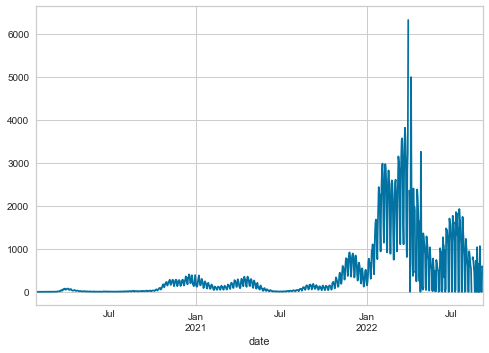

In [ ]:
df_country['new_cases_per_million'].plot()

<AxesSubplot:xlabel='date'>

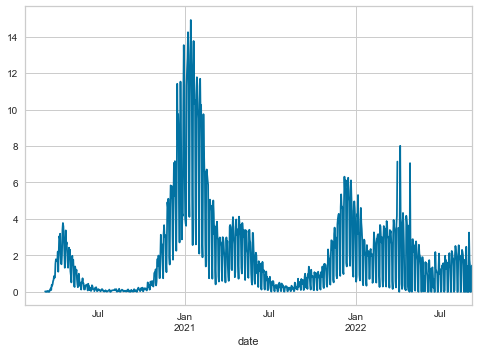

In [ ]:
df_country['new_deaths_per_million'].plot()

<AxesSubplot:xlabel='date'>

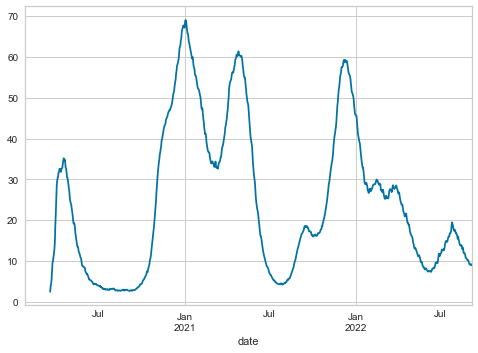

In [ ]:
df_country['icu_patients_per_million'].plot()

In [ ]:
# check missing data
df_country.isna().sum()

location                     0
new_cases_per_million        2
new_deaths_per_million      45
icu_patients_per_million    53
dtype: int64

In [ ]:
# fill nas in ts
df_country = ts_filling(df_country)

In [ ]:
# check missing data
df_country.isna().sum()

location                    0
new_cases_per_million       0
new_deaths_per_million      0
icu_patients_per_million    0
dtype: int64

<AxesSubplot:xlabel='date'>

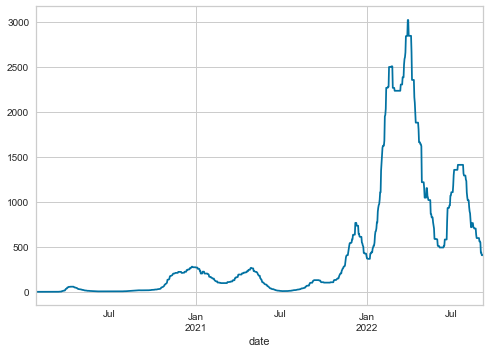

In [ ]:
# smooth time series
df_country['new_cases_per_million'].plot()

<AxesSubplot:xlabel='date'>

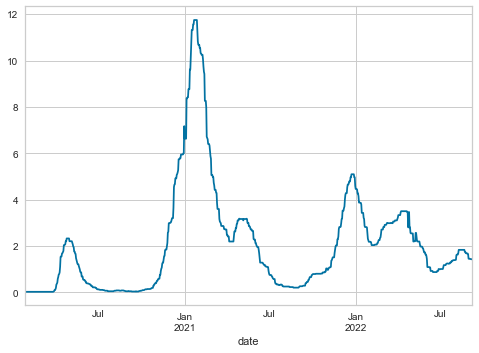

In [ ]:
df_country['new_deaths_per_million'].plot()

<AxesSubplot:xlabel='date'>

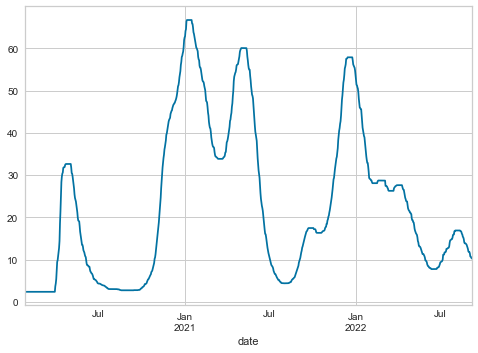

In [ ]:
df_country['icu_patients_per_million'].plot()

# Feature Engineering

In [ ]:
df_country

,location,new_cases_per_million,new_deaths_per_million,icu_patients_per_million
date,,,,
2020-01-27,Germany,0.000,0.024,2.398
2020-01-28,Germany,0.000,0.024,2.398
2020-01-29,Germany,0.000,0.024,2.398
2020-01-30,Germany,0.000,0.024,2.398
2020-01-31,Germany,0.000,0.024,2.398
...,...,...,...,...
2022-09-02,Germany,435.147,1.439,11.486
2022-09-03,Germany,435.147,1.439,10.754
2022-09-04,Germany,406.793,1.439,10.706


In [ ]:
# calculate new deaths percent change 
df_country = add_new_deaths_pct_change(df_country)
# calculate case fatality rate
df_country = add_case_fatality_rate(df_country)

In [ ]:
df_country

,location,new_cases_per_million,new_deaths_per_million,icu_patients_per_million,new_deaths_per_million_pct_change,case_fatality_rate
date,,,,,,
2020-01-27,Germany,0.000,0.024,2.398,0.000000,0.000000
2020-01-28,Germany,0.000,0.024,2.398,0.000000,0.000000
2020-01-29,Germany,0.000,0.024,2.398,0.000000,0.000000
2020-01-30,Germany,0.000,0.024,2.398,0.000000,0.000000
2020-01-31,Germany,0.000,0.024,2.398,0.000000,0.000000
...,...,...,...,...,...,...
2022-09-02,Germany,435.147,1.439,11.486,-0.215376,0.002045
2022-09-03,Germany,435.147,1.439,10.754,-0.215376,0.002045
2022-09-04,Germany,406.793,1.439,10.706,-0.215376,0.002045


<AxesSubplot:xlabel='date'>

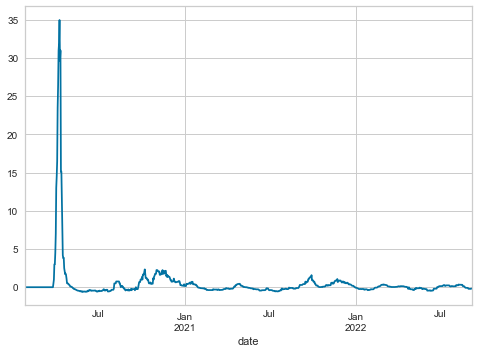

In [ ]:
df_country['new_deaths_per_million_pct_change'].plot()

<AxesSubplot:xlabel='date'>

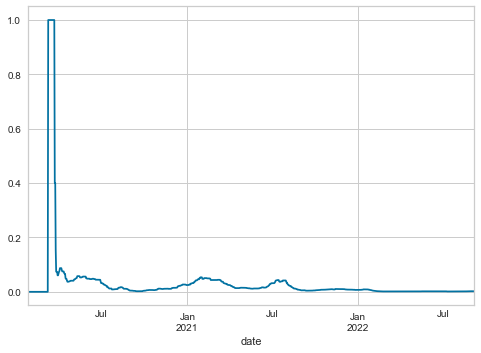

In [ ]:
df_country['case_fatality_rate'].plot()

# Add Target

In [ ]:
df_country

,location,new_cases_per_million,new_deaths_per_million,icu_patients_per_million,new_deaths_per_million_pct_change,case_fatality_rate
date,,,,,,
2020-01-27,Germany,0.000,0.024,2.398,0.000000,0.000000
2020-01-28,Germany,0.000,0.024,2.398,0.000000,0.000000
2020-01-29,Germany,0.000,0.024,2.398,0.000000,0.000000
2020-01-30,Germany,0.000,0.024,2.398,0.000000,0.000000
2020-01-31,Germany,0.000,0.024,2.398,0.000000,0.000000
...,...,...,...,...,...,...
2022-09-02,Germany,435.147,1.439,11.486,-0.215376,0.002045
2022-09-03,Germany,435.147,1.439,10.754,-0.215376,0.002045
2022-09-04,Germany,406.793,1.439,10.706,-0.215376,0.002045


In [ ]:
# add target i.e. deaths in 21 days
#df_country['new_deaths_per_million' + '_future'] = df_country['new_deaths_per_million'].shift(-14)
forecast_horizont = 14
target_name = 'icu_patients_per_million' + '_' + str(forecast_horizont) + 'days_ahead'
df_country[target_name] = df_country['icu_patients_per_million'].shift(-forecast_horizont)
df_country.dropna(axis=0, inplace=True)
df_country

,location,new_cases_per_million,new_deaths_per_million,icu_patients_per_million,new_deaths_per_million_pct_change,case_fatality_rate,icu_patients_per_million_14days_ahead
date,,,,,,,
2020-01-27,Germany,0.000,0.024,2.398,0.000000,0.000000,2.398
2020-01-28,Germany,0.000,0.024,2.398,0.000000,0.000000,2.398
2020-01-29,Germany,0.000,0.024,2.398,0.000000,0.000000,2.398
2020-01-30,Germany,0.000,0.024,2.398,0.000000,0.000000,2.398
2020-01-31,Germany,0.000,0.024,2.398,0.000000,0.000000,2.398
...,...,...,...,...,...,...,...
2022-08-19,Germany,703.585,1.834,15.274,0.124464,0.001490,11.486
2022-08-20,Germany,703.585,1.834,14.879,0.124464,0.001663,10.754
2022-08-21,Germany,703.585,1.834,14.135,0.124464,0.001745,10.706


# Simple Analytical Model

In [ ]:
#df_country

In [ ]:
## the simple model calculates the deaths simply as the new cases multiplied by the case fatality rate
#df_country['simple_prediction'] = df_country['new_cases_per_million'] * df_country['case_fatality_rate']
## apply some smoothing
#df_country['simple_prediction'] = df_country['simple_prediction'].rolling(14).median()
#df_country['simple_prediction'].fillna(value=None, method='bfill', axis=0, inplace=True, limit=30, downcast=None)
### drop nas
##df_country.dropna(axis=0, inplace=True)

In [ ]:
#df_country

In [ ]:
#df_country['new_deaths_per_million_future'].plot()
#df_country['simple_prediction'].plot()

# Train Test Split

In [ ]:
split_date = '2021-03-10'

In [ ]:
fig = px.line(df_country, x=df_country.index, y=['icu_patients_per_million'], title = country, template = 'plotly_dark')

fig.add_vline(x=split_date, line_width=3, line_dash="dash", line_color="red")

start_date, end_date = get_start_end_date(df_country)
fig.add_vrect(x0=start_date, x1=split_date, row="all", col=1,
              annotation_text="training period", annotation_position="top left",
              fillcolor="green", opacity=0.15, line_width=0)

fig.add_vrect(x0=split_date, x1=end_date, row="all", col=1,
              annotation_text="testing period", annotation_position="top left",
              fillcolor="red", opacity=0.15, line_width=0)

fig.show()

In [ ]:
df_train, df_test = train_test_split(df_country, split_date = split_date)

In [ ]:
df_train.columns

Index(['location', 'new_cases_per_million', 'new_deaths_per_million',
       'icu_patients_per_million', 'new_deaths_per_million_pct_change',
       'case_fatality_rate', 'icu_patients_per_million_14days_ahead'],
      dtype='object')

# Modeling

In [ ]:
# initialize setup from pycaret.regression
s = setup(df_train, 
        target = target_name,
        ignore_features = ['location', 'new_cases_per_million', 'new_deaths_per_million_pct_change'],
        #ignore_features = ['location'],
        train_size = .99,
        data_split_shuffle = False, 
        fold_strategy = 'timeseries', fold=2,
        imputation_type = 'simple',
        numeric_imputation = 'median',
        remove_multicollinearity = True,
        multicollinearity_threshold = 0.4,
        feature_interaction=True,
        polynomial_features=False,
        remove_outliers = False,
        transform_target=False,
        transformation = False,
        normalize = False,
        feature_selection = False,
        feature_selection_method='boruta',
        feature_selection_threshold = 0.3,
        silent = True, 
        verbose = True, 
        session_id = 123)

,Description,Value
0,session_id,123
1,Target,icu_patients_per_million_14days_ahead
2,Original Data,"(866, 7)"
3,Missing Values,False
4,Numeric Features,3
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(857, 3)"


In [ ]:
# compare all models and select best one based on MAE
best_model = compare_models(#include=['xgboost', 'dummy', 'lr', 'lightgbm'],
                            include=['xgboost', 'lightgbm','dt','gbr'],
                            #include=['xgboost', 'lightgbm','lr'],
                            #include=['lr','dummy'],
                            sort='R2', 
                            verbose=True,
                            n_select = 1)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,14.4311,278.1415,16.6099,0.0019,0.5519,0.6343,1.1500
dt,Decision Tree Regressor,14.4391,292.2847,16.9325,-0.0070,0.5736,0.6485,1.1350
lightgbm,Light Gradient Boosting Machine,15.1481,309.1774,17.4374,-0.0739,0.5744,0.6437,1.1350
xgboost,Extreme Gradient Boosting,15.2255,314.8239,17.6875,-0.1399,0.5834,0.6751,2.3900


In [ ]:
best_model = tune_model(best_model)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,15.4167,359.6767,18.9651,0.1571,0.5801,0.5039
1,7.9222,84.0341,9.1670,0.5481,0.3865,0.4215
Mean,11.6695,221.8554,14.0661,0.3526,0.4833,0.4627
Std,3.7473,137.8213,4.8991,0.1955,0.0968,0.0412


In [ ]:
evaluate_model(best_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [ ]:
# finalize model on all training data
best_model = finalize_model(best_model)

In [ ]:
# predict on training set
forecast_name = str(forecast_horizont) + 'days_ahead_forecast'

df_train = predict_model(best_model, data=df_train, round=1, verbose=False)
df_train.rename(columns={'Label': forecast_name}, inplace=True) # rename prediction column
# predict on testing set
df_test = predict_model(best_model, data=df_test, round=1, verbose=False)
df_test.rename(columns={'Label': forecast_name}, inplace=True) # rename prediction column
# predict on whole dataset
df_country = predict_model(best_model, data=df_country, round=1, verbose=False)
df_country.rename(columns={'Label': forecast_name}, inplace=True) # rename prediction column

In [ ]:
fig = px.line(df_country, x=df_country.index, y=['icu_patients_per_million',
                                                 forecast_name], title = country, template = 'plotly_dark')

fig.add_vline(x=split_date, line_width=3, line_dash="dash", line_color="red")

start_date, end_date = get_start_end_date(df_country)
fig.add_vrect(x0=start_date, x1=split_date, row="all", col=1,
              annotation_text="training period", annotation_position="top left",
              fillcolor="green", opacity=0.15, line_width=0)

fig.add_vrect(x0=split_date, x1=end_date, row="all", col=1,
              annotation_text="testing period", annotation_position="top left",
              fillcolor="red", opacity=0.15, line_width=0)

fig.show()

# ToDo

In [ ]:
# download once per day and store in data folder-------------------ok
# predict hospitalization----------------------------------ok
# drop countries with too much missing data-----------------------ok
# correct forecast on time axis-----------------------ok
# show train test split in final figure--------------ok
# make streamlit app and deploy with ci/cd